In [ ]:
#code taken from https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb
#@title Run to install MuJoCo and `dm_control`
import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

print('Installing dm_control...')
!pip install -q dm_control>=1.0.8

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl
# %env MUJOCO_GL=osmesa

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

#other dependencies
%pip install -q git+https://github.com/deepmind/acme.git#egg=dm-acme[jax,tf,envs]
%pip install -q imageio-ffmpeg
%pip install -q gdown
%pip install rsatoolbox
%pip install --upgrade numpy

!pip install smart_open[s3]

# download the pretrained weights
import gdown
gdown.download("https://drive.google.com/file/d/13Xug1PoJ3bl3Ya9MTM0p-AR513mtsIVR/view?usp=share_link", fuzzy=True)

In [2]:
quit() # continue with the rest of the notebook after restarting the notebook

In [1]:
#@title More imports and constants
# plot the activations
# %matplotlib inline


from sklearn.decomposition import PCA

# try out the wrappers
from acme import wrappers
from dm_control import suite
import tree

import imageio
from PIL import Image
import io

IMG_HEIGHT = 256
IMG_WIDTH = 256

# visualizations
from rsatoolbox import vis
from rsatoolbox import rdm
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#@title SAC code
# sac code
import os
import random
import math
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import Adam

LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6

#@title Environment wrappers
from dm_env import specs


/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.8/dist-packages/glfw/__init__.py:912: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


In [2]:
#@title SAC code
# sac code
import os
import random
import math
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import Adam

"""
From model.py
"""
LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6


# Initialize Policy weights
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)


class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_dim):
        super(ValueNetwork, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class QNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(QNetwork, self).__init__()

        # Q1 architecture
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

        # Q2 architecture
        self.linear4 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.linear5 = nn.Linear(hidden_dim, hidden_dim)
        self.linear6 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state, action):
        xu = torch.cat([state, action], 1)

        x1 = F.relu(self.linear1(xu))
        x1 = F.relu(self.linear2(x1))
        x1 = self.linear3(x1)

        x2 = F.relu(self.linear4(xu))
        x2 = F.relu(self.linear5(x2))
        x2 = self.linear6(x2)

        return x1, x2


class GaussianPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space=None):
        super(GaussianPolicy, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean_linear = nn.Linear(hidden_dim, num_actions)
        self.log_std_linear = nn.Linear(hidden_dim, num_actions)

        self.apply(weights_init_)

        # action rescaling
        if action_space is None:
            self.action_scale = torch.tensor(1.)
            self.action_bias = torch.tensor(0.)
        else:
            self.action_scale = torch.FloatTensor(
                (action_space.maximum - action_space.minimum) / 2.)
            self.action_bias = torch.FloatTensor(
                (action_space.maximum + action_space.minimum) / 2.)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

    def to(self, device):
        self.action_scale = self.action_scale.to(device)
        self.action_bias = self.action_bias.to(device)
        return super(GaussianPolicy, self).to(device)


class DeterministicPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space=None):
        super(DeterministicPolicy, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean = nn.Linear(hidden_dim, num_actions)
        self.noise = torch.Tensor(num_actions)

        self.apply(weights_init_)

        # action rescaling
        if action_space is None:
            self.action_scale = 1.
            self.action_bias = 0.
        else:
            self.action_scale = torch.FloatTensor(
                (action_space.maximum - action_space.minimum) / 2.)
            self.action_bias = torch.FloatTensor(
                (action_space.maximum + action_space.minimum) / 2.)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = torch.tanh(self.mean(x)) * self.action_scale + self.action_bias
        return mean

    def sample(self, state):
        mean = self.forward(state)
        noise = self.noise.normal_(0., std=0.1)
        noise = noise.clamp(-0.25, 0.25)
        action = mean + noise
        return action, torch.tensor(0.), mean

    def to(self, device):
        self.action_scale = self.action_scale.to(device)
        self.action_bias = self.action_bias.to(device)
        self.noise = self.noise.to(device)
        return super(DeterministicPolicy, self).to(device)


"""
From utils.py
"""


def create_log_gaussian(mean, log_std, t):
    quadratic = -((0.5 * (t - mean) / (log_std.exp())).pow(2))
    l = mean.shape
    log_z = log_std
    z = l[-1] * math.log(2 * math.pi)
    log_p = quadratic.sum(dim=-1) - log_z.sum(dim=-1) - 0.5 * z
    return log_p


def logsumexp(inputs, dim=None, keepdim=False):
    if dim is None:
        inputs = inputs.view(-1)
        dim = 0
    s, _ = torch.max(inputs, dim=dim, keepdim=True)
    outputs = s + (inputs - s).exp().sum(dim=dim, keepdim=True).log()
    if not keepdim:
        outputs = outputs.squeeze(dim)
    return outputs


def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)


def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)


"""
From replay_memory.py
"""


class ReplayMemory:
    def __init__(self, capacity, seed):
        random.seed(seed)
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

    def save_buffer(self, env_name, suffix="", save_path=None):
        if not os.path.exists('checkpoints/'):
            os.makedirs('checkpoints/')

        if save_path is None:
            save_path = "checkpoints/sac_buffer_{}_{}".format(env_name, suffix)
        print('Saving buffer to {}'.format(save_path))

        with open(save_path, 'wb') as f:
            pickle.dump(self.buffer, f)

    def load_buffer(self, save_path):
        print('Loading buffer from {}'.format(save_path))

        with open(save_path, "rb") as f:
            self.buffer = pickle.load(f)
            self.position = len(self.buffer) % self.capacity


"""
From sac.py
"""


class SAC(object):
    def __init__(self, num_inputs, action_space, args):

        self.gamma = args.gamma
        self.tau = args.tau
        self.alpha = args.alpha

        self.policy_type = args.policy
        self.target_update_interval = args.target_update_interval
        self.automatic_entropy_tuning = args.automatic_entropy_tuning

        self.device = torch.device("cuda" if args.cuda else "cpu")

        self.critic = QNetwork(num_inputs, action_space.shape[0], args.hidden_size).to(device=self.device)
        self.critic_optim = Adam(self.critic.parameters(), lr=args.lr)

        self.critic_target = QNetwork(num_inputs, action_space.shape[0], args.hidden_size).to(self.device)
        hard_update(self.critic_target, self.critic)

        if self.policy_type == "Gaussian":
            # Target Entropy = −dim(A) (e.g. , -6 for HalfCheetah-v2) as given in the paper
            if self.automatic_entropy_tuning is True:
                self.target_entropy = -torch.prod(torch.Tensor(action_space.shape).to(self.device)).item()
                self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
                self.alpha_optim = Adam([self.log_alpha], lr=args.lr)

            self.policy = GaussianPolicy(num_inputs, action_space.shape[0], args.hidden_size, action_space).to(
                self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=args.lr)

        else:
            self.alpha = 0
            self.automatic_entropy_tuning = False
            self.policy = DeterministicPolicy(num_inputs, action_space.shape[0], args.hidden_size, action_space).to(
                self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=args.lr)

    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        if evaluate is False:
            action, _, _ = self.policy.sample(state)
        else:
            _, _, action = self.policy.sample(state)
        return action.detach().cpu().numpy()[0]

    def update_parameters(self, memory, batch_size, updates):
        # Sample a batch from memory
        state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(batch_size=batch_size)

        state_batch = torch.FloatTensor(state_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device).unsqueeze(1)
        mask_batch = torch.FloatTensor(mask_batch).to(self.device).unsqueeze(1)

        with torch.no_grad():
            next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_q_value = reward_batch + mask_batch * self.gamma * (min_qf_next_target)
        qf1, qf2 = self.critic(state_batch,
                               action_batch)  # Two Q-functions to mitigate positive bias in the policy improvement step
        qf1_loss = F.mse_loss(qf1, next_q_value)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        qf2_loss = F.mse_loss(qf2, next_q_value)  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        qf_loss = qf1_loss + qf2_loss

        self.critic_optim.zero_grad()
        qf_loss.backward()
        self.critic_optim.step()

        pi, log_pi, _ = self.policy.sample(state_batch)

        qf1_pi, qf2_pi = self.critic(state_batch, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)

        policy_loss = ((
                               self.alpha * log_pi) - min_qf_pi).mean()  # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]

        self.policy_optim.zero_grad()
        policy_loss.backward()
        self.policy_optim.step()

        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()

            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()

            self.alpha = self.log_alpha.exp()
            alpha_tlogs = self.alpha.clone()  # For TensorboardX logs
        else:
            alpha_loss = torch.tensor(0.).to(self.device)
            alpha_tlogs = torch.tensor(self.alpha)  # For TensorboardX logs

        if updates % self.target_update_interval == 0:
            soft_update(self.critic_target, self.critic, self.tau)

        return qf1_loss.item(), qf2_loss.item(), policy_loss.item(), alpha_loss.item(), alpha_tlogs.item()

    # Save model parameters
    def save_checkpoint(self, env_name, suffix="", ckpt_path=None):
        if not os.path.exists('checkpoints/'):
            os.makedirs('checkpoints/')
        if ckpt_path is None:
            ckpt_path = "checkpoints/sac_checkpoint_{}_{}".format(env_name, suffix)
        print('Saving models to {}'.format(ckpt_path))
        torch.save({'policy_state_dict': self.policy.state_dict(),
                    'critic_state_dict': self.critic.state_dict(),
                    'critic_target_state_dict': self.critic_target.state_dict(),
                    'critic_optimizer_state_dict': self.critic_optim.state_dict(),
                    'policy_optimizer_state_dict': self.policy_optim.state_dict()}, ckpt_path)

    # Load model parameters
    def load_checkpoint(self, ckpt_path, evaluate=False):
        print('Loading models from {}'.format(ckpt_path))
        if ckpt_path is not None:
            checkpoint = torch.load(ckpt_path)
            self.policy.load_state_dict(checkpoint['policy_state_dict'])
            self.critic.load_state_dict(checkpoint['critic_state_dict'])
            self.critic_target.load_state_dict(checkpoint['critic_target_state_dict'])
            self.critic_optim.load_state_dict(checkpoint['critic_optimizer_state_dict'])
            self.policy_optim.load_state_dict(checkpoint['policy_optimizer_state_dict'])

            if evaluate:
                self.policy.eval()
                self.critic.eval()
                self.critic_target.eval()
            else:
                self.policy.train()
                self.critic.train()
                self.critic_target.train()

In [3]:
# @title Environment wrappers
from dm_env import specs


# environment wrappers
class NormilizeActionSpecWrapper(wrappers.EnvironmentWrapper):
    """Turn each dimension of the actions into the range of [-1, 1]."""

    def __init__(self, environment):
        super().__init__(environment)

        action_spec = environment.action_spec()
        self._scale = action_spec.maximum - action_spec.minimum
        self._offset = action_spec.minimum

        minimum = action_spec.minimum * 0 - 1.
        maximum = action_spec.minimum * 0 + 1.
        self._action_spec = specs.BoundedArray(
            action_spec.shape,
            action_spec.dtype,
            minimum,
            maximum,
            name=action_spec.name)

    def _from_normal_actions(self, actions):
        actions = 0.5 * (actions + 1.0)  # a_t is now in the range [0, 1]
        # scale range to [minimum, maximum]
        return actions * self._scale + self._offset

    def step(self, action):
        action = self._from_normal_actions(action)
        return self._environment.step(action)

    def action_spec(self):
        return self._action_spec


class MujocoActionNormalizer(wrappers.EnvironmentWrapper):
    """Rescale actions to [-1, 1] range for mujoco physics engine.

    For control environments whose actions have bounded range in [-1, 1], this
      adaptor rescale actions to the desired range. This allows actor network to
      output unscaled actions for better gradient dynamics.
    """

    def __init__(self, environment, rescale='clip'):
        super().__init__(environment)
        self._rescale = rescale

    def step(self, action):
        """Rescale actions to [-1, 1] range before stepping wrapped environment."""
        if self._rescale == 'tanh':
            scaled_actions = tree.map_structure(np.tanh, action)
        elif self._rescale == 'clip':
            scaled_actions = tree.map_structure(lambda a: np.clip(a, -1., 1.), action)
        else:
            raise ValueError('Unrecognized scaling option: %s' % self._rescale)
        return self._environment.step(scaled_actions)



In [4]:
#@title Helper functions
# helper functions

def create_stitched_img(env, num_cams=2, img_height=256, img_width=256):
    tmp_img_arr = []

    # stitch all the views together
    for i in range(num_cams):
        img = env.physics.render(img_height, img_width, camera_id=i)
        im = Image.fromarray(img)
        # save temporarily
        tmp_img_arr.append(im)

    # stitch the images together
    # get the width and height of the images
    widths, heights = zip(*(i.size for i in tmp_img_arr))
    # get the total width and height
    total_width = sum(widths)
    max_height = max(heights)
    # create a new image
    new_im = Image.new('RGB', (total_width, max_height))
    # paste the images together
    x_offset = 0
    for im in tmp_img_arr:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    return new_im


def get_flat_obs(time_step):
    # flatten all of the observations into a single array
    flat_obs = tree.flatten(time_step.observation)
    # combine all of the observations into a single array
    obs = np.concatenate(flat_obs)
    return obs


def save_video(img_arr, video_name='video.mp4', fps=30):
    """
    Save a video from a list of images
    :param img_arr: list of images
    :type img_arr: list
    :param video_name: name of the video
    :type video_name: str
    :param fps: frames per second
    :type fps: int
    :return: True if successful
    :rtype: bool
    """
    video_path = os.path.join(os.getcwd(), video_name)
    writer = imageio.get_writer(video_path, fps=30)
    for img in img_arr:
        writer.append_data(np.array(img))
    writer.close()
    return True


# create hook function to record activations
def hook_fn(module, input, output):
    print('hook_fn called')
    print('layer name:', module.__class__.__name__)
    # print('input:', input)
    print('output:', output.shape)


def named_hook_fn(name):
    def hook_fn(module, input, output):
        print('hook_fn called')
        print('layer class:', module.__class__.__name__)
        print('name:', name)
        # print('input:', input)
        print('output:', output.shape)

    return hook_fn


def recordtodict_hook(name, hook_dict):
    def hook_fn(module, input, output):
        # append to the corresponding list
        hook_dict[name] += output.clone().detach()
        # hook_dict[name] += output.detach()

    return hook_fn


# add hooks
def test_add_hooks(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            module.register_forward_hook(named_hook_fn(name))


# initialize a hook_dict that contains an empty list for each layer
def init_hook_dict(model):
    hook_dict = {}
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            hook_dict[name] = []
    return hook_dict


# compile the hook dict into a dict of numpy arrays
def compile_hook_dict(hook_dict):
    compiled_hook_dict = {}
    for name, hook_list in hook_dict.items():
        if len(hook_list) > 0:
            compiled_hook_dict[name] = torch.stack(hook_list, dim=0).detach().cpu().numpy()
    return compiled_hook_dict


# save the hook_dict to a file
def save_hook_dict(hook_dict, save_path):
    # compile the hook_dict
    compiled_hook_dict = compile_hook_dict(hook_dict)
    # save the compiled_hook_dict
    np.save(save_path, compiled_hook_dict)


# load the hook_dict from a file
def load_hook_dict(load_path):
    compiled_hook_dict = np.load(load_path, allow_pickle=True).item()
    return compiled_hook_dict


def clear_hook_dict(hook_dict):
    # clears the items in hook dict in-place
    for name, hook_list in hook_dict.items():
        hook_list.clear()


# save the PCA
def save_pca_dict(pca_dict, save_path):
    np.save(save_path, pca_dict)


# load the PCA
def load_pca_dict(load_path):
    pca_dict = np.load(load_path, allow_pickle=True).item()
    return pca_dict


def get_activations(pca_dict, compiled_hook_dict, layer_name, num_components=2):
    # get the activations
    activations = compiled_hook_dict[layer_name]
    # get the pca
    pca = pca_dict[layer_name]
    # get the transformed activations
    transformed_activations = pca.transform(activations)
    return transformed_activations


def plot_activations(activations, layer_name=None, save_path=None, show=False):
    # assumes 2 components
    # grab x and y
    x, y = activations[:, 0], activations[:, 1]
    # plot the activations
    fig, ax = plt.subplots(figsize=(10, 10))
    _ = ax.scatter(x, y, s=1)
    _ = ax.set_xlabel('PC1')
    _ = ax.set_ylabel('PC2')
    if layer_name is not None:
        ax.set_title(layer_name)
    if save_path is not None:
        plt.savefig(save_path)
    if show:
        plt.show()

    return fig


def plot_single_point(point, activations, pca, layer_name=None):
    transformed = pca.transform(point)
    # make a scatterplot
    fig, ax = plt.subplots(figsize=(10, 10))
    _ = ax.scatter(activations[:, 0], activations[:, 1], s=1, alpha=0.5)
    # overlay our current dot
    _ = ax.scatter(transformed[:, 0], transformed[:, 1], s=100, alpha=1, c='r')

    if layer_name is not None:
        _ = ax.set_title(layer_name)

    # get the image
    fig_im = fig2img(fig)
    fig_im = fig_im.resize((IMG_HEIGHT, IMG_WIDTH))

    plt.close()

    return fig_im


# # convert a matplotlib figure to an image
# def fig2img(fig):
#     # draw the renderer
#     fig.canvas.draw()
#
#     # Get the RGBA buffer from the figure
#     w, h = fig.canvas.get_width_height()
#     buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
#     buf.shape = (w, h, 3)
#
#     # # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
#     # buf = np.roll(buf, 3, axis=2)
#     return buf

def fig2img(fig):
    """
    Convert a Matplotlib figure to a PIL Image and return it
    https://stackoverflow.com/a/61754995
    """
    buf = io.BytesIO()
    _ = fig.savefig(buf)
    _ = buf.seek(0)
    img = Image.open(buf)
    img = img.convert('RGB')
    return img

def get_kinematics(physics, geom_nams, joint_names, actuator_names):
    geom_positions = physics.named.data.geom_xpos[geom_nams]
    joint_angles = physics.named.data.qpos[joint_names]
    joint_velocities = physics.named.data.qvel[joint_names]
    actuator_forces = physics.named.data.actuator_force[actuator_names]

    return {
        'geom_positions': geom_positions,
        'joint_angles': joint_angles,
        'joint_velocities': joint_velocities,
        'actuator_forces': actuator_forces
    }




## Environment and agent setup

**NOTE: Make sure you download the pretrained weights or upload your own weights before running this cell!**

In [5]:
# download the pretrained weights
import gdown
gdown.download("https://drive.google.com/file/d/13Xug1PoJ3bl3Ya9MTM0p-AR513mtsIVR/view?usp=share_link", fuzzy=True)

/usr/local/lib/python3.8/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
Downloading...
From: https://drive.google.com/uc?id=13Xug1PoJ3bl3Ya9MTM0p-AR513mtsIVR
To: /content/sac_checkpoint_cheetah_123456_10000
100%|██████████| 3.22M/3.22M [00:00<00:00, 185MB/s]


'sac_checkpoint_cheetah_123456_10000'

In [6]:
# load the environment
env = suite.load(domain_name="cheetah", task_name="run")
# add wrappers onto the environment
env = NormilizeActionSpecWrapper(env)
env = MujocoActionNormalizer(environment=env, rescale='clip')
env = wrappers.SinglePrecisionWrapper(env)


class Args:
    env_name = 'whatever'
    policy = 'Gaussian'
    eval = True
    gamma = 0.99
    tau = 0.005
    lr = 0.0003
    alpha = 0.2
    automatic_entropy_tuning = True
    seed = 42
    batch_size = 256
    num_steps = 1000000
    hidden_size = 256
    updates_per_step = 1
    start_steps = 10000
    target_update_interval = 1
    replay_size = 1000000
    cuda = False


args = Args()

# get the dimensionality of the observation_spec after flattening
flat_obs = tree.flatten(env.observation_spec())
# combine all the shapes
obs_dim = sum([item.shape[0] for item in flat_obs])

# setup agent
agent = SAC(obs_dim, env.action_spec(), args)

# load checkpoint - UPLOAD YOUR FILE HERE!
model_path = '/content/sac_checkpoint_cheetah_123456_10000'
# model_path = 's3://cheetah-checkpoint/sac_checkpoint_cheetah_123456_10000'
agent.load_checkpoint(model_path, evaluate=True)

   
# model_path = 's3://cheetah-checkpoint/sac_checkpoint_cheetah_123456_10000'
# with smart_open(model_path, 'rb') as f:
#     buffer = io.BytesIO(f.read())
#     agent.load_checkpoint(buffer, evaluate=True)

# pull out model
model = agent.policy
# setup hook dict
hook_dict = init_hook_dict(model)
# add hooks
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        module.register_forward_hook(recordtodict_hook(name=name, hook_dict=hook_dict))

Loading models from /content/sac_checkpoint_cheetah_123456_10000


## Collecting activations and kinematics

In [7]:
CHEETAH_GEOM_NAMES = ['ground', 'torso', 'head', 'bthigh', 'bshin', 'bfoot', 'fthigh', 'fshin', 'ffoot']
CHEETAH_JOINT_NAMES = ['bthigh', 'bshin', 'bfoot', 'fthigh', 'fshin', 'ffoot']
CHEETAH_ACTUATOR_NAMES = ['bthigh', 'bshin', 'bfoot', 'fthigh', 'fshin', 'ffoot']

# get the mapping of the geom names
geom_names_to_idx = {geom_name: idx for idx, geom_name in enumerate(CHEETAH_GEOM_NAMES)}
# get the mapping of the joint names
joint_names_to_idx = {joint_name: idx for idx, joint_name in enumerate(CHEETAH_JOINT_NAMES)}
# get the mapping of the actuator names
actuator_names_to_idx = {actuator_name: idx for idx, actuator_name in enumerate(CHEETAH_ACTUATOR_NAMES)}

In [8]:
# run a few episodes just to collect activations
num_episodes_to_run = 10

# for recording kinematics
total_kinematic_dict = {
    'geom_positions': [],
    'joint_angles': [],
    'joint_velocities': [],
    'actuator_forces': []
}

for i in range(num_episodes_to_run):
    time_step = env.reset()
    episode_reward = 0
    while not time_step.last():  # or env.get_termination()
        # get the state
        state = get_flat_obs(time_step)
        # sample an action
        action = agent.select_action(state)
        time_step = env.step(action)

        # record kinematics
        kinematic_dict = get_kinematics(env.physics, CHEETAH_GEOM_NAMES, CHEETAH_JOINT_NAMES, CHEETAH_ACTUATOR_NAMES)
        total_kinematic_dict['geom_positions'].append(kinematic_dict['geom_positions'])
        total_kinematic_dict['joint_angles'].append(kinematic_dict['joint_angles'])
        total_kinematic_dict['joint_velocities'].append(kinematic_dict['joint_velocities'])
        total_kinematic_dict['actuator_forces'].append(kinematic_dict['actuator_forces'])
        # record reward
        episode_reward += time_step.reward
    print('Episode: {} Reward: {}'.format(i, episode_reward))

Episode: 0 Reward: 917.5926761943847
Episode: 1 Reward: 915.1967064272612
Episode: 2 Reward: 917.6093530226499
Episode: 3 Reward: 913.87397807464
Episode: 4 Reward: 922.6018928270787
Episode: 5 Reward: 908.7027169186622
Episode: 6 Reward: 910.1180084273219
Episode: 7 Reward: 917.6959071494639
Episode: 8 Reward: 923.4428509604186
Episode: 9 Reward: 920.9642459414899


In [9]:
#### optional: save + load the hook_dict
# save_path = 'hook_dict.npy'
# save_hook_dict(hook_dict, save_path)

# load_path = 'hook_dict.npy'
# loaded_hook_dict = load_hook_dict(load_path)


In [9]:
# otherwise, just compile the hook_dict
loaded_hook_dict = compile_hook_dict(hook_dict)

In [10]:
# process the kinematics - convert the kinematics to numpy arrays
total_kinematic_dict['geom_positions'] = np.stack(total_kinematic_dict['geom_positions'],
                                                  axis=0)  # combine the geom_positions_arr into (t, n, 3)
total_kinematic_dict['joint_angles'] = np.array(total_kinematic_dict['joint_angles'])
total_kinematic_dict['joint_velocities'] = np.array(total_kinematic_dict['joint_velocities'])
total_kinematic_dict['actuator_forces'] = np.array(total_kinematic_dict['actuator_forces'])

In [ ]:
# #save kinematic data in a txt file. Can change to json by modifying the file extension
# with open("kinematic_data.txt", "w") as fp:
#     fp.write(str(total_kinematic_dict))

# #save the activation data in a txt file. Can change to json by modifying the file extension 
# with open("activation_data.txt", "w") as fp:
#     fp.write(str(loaded_hook_dict))

In [ ]:
# # example 1: get the joint angles for the bthigh
# bthigh_joint_angles = total_kinematic_dict['joint_angles'][:, joint_names_to_idx['bthigh']]

# # example 2: get the geom positions for the torso
# torso_geom_positions = total_kinematic_dict['geom_positions'][:, geom_names_to_idx['torso'], :]

TSNE over kinematic data

In [ ]:
from sklearn.manifold import TSNE

# plot data for geom_positions
x_3d = total_kinematic_dict['geom_positions']
y = geom_names_to_idx.keys()

# reshape data from 3d to 2d
nsamples, nx, ny = x_3d.shape
x = x_3d.reshape((nsamples,nx*ny))

tsne = TSNE(n_components=2)
z = tsne.fit_transform(x)

In [ ]:
# plot data for joint_angles
x = total_kinematic_dict['joint_angles']
y = joint_names_to_idx.keys()

tsne = TSNE(n_components=2)
z = tsne.fit_transform(x)

In [ ]:
import pandas as pd
import seaborn as sns

%matplotlib inline

# df = pd.DataFrame()
# df["y"] = y
# df["comp-1"] = z[:,0]
# df["comp-2"] = z[:,1]

sns.scatterplot(x=z[:,0], y=z[:,1], palette=sns.color_palette("hls", 6)).set(title="Kinematic Geometric Positional data T-SNE projection") 

## Example: Using PCA to visualize activations

In [ ]:
# do pca on the activations
pca_dict = {}
for name, arr in loaded_hook_dict.items():
    pca = PCA(n_components=2)
    pca.fit(arr)
    pca_dict[name] = pca

In [ ]:
#### optional: save + load the pca_dict
# save_path = 'pca_dict.npy'
# save_pca_dict(pca_dict, save_path)
# loaded_pca_dict = load_pca_dict(save_path)

In [ ]:
# %matplotlib inline  # uncomment if you want to see the plots inline
# plot the activations, and save the activations to a dictionary
os.makedirs('activations', exist_ok=True)

activations_dict = {}
for name, pca in pca_dict.items():
    # get activations
    activations = get_activations(pca_dict=pca_dict, compiled_hook_dict=loaded_hook_dict, layer_name=name)

    # save activations
    activations_dict[name] = activations

    # plot activations
    save_path = 'activations/{}.png'.format(name)
    fig_im = plot_activations(activations, layer_name=name, save_path=save_path, show=True)

# CKA

In [11]:
def cka(X,Y):
    # CKA formula from Kornblith et al.,(2019)

    # making a copy prevents modifying original arrays
    X = X.copy()
    Y = Y.copy()

    # center x and y first to do dot product
    X -= X.mean(axis=0)
    Y -= Y.mean(axis=0)

    # dot products
    x_xt = X.T.dot(X)
    y_yt = Y.T.dot(Y)
    x_yt = Y.T.dot(X)

    # Frobenius norm = root of the sum of squares of the entries when X and Y are centered
    return (x_yt**2).sum() / np.sqrt((x_xt**2).sum() * (y_yt**2).sum())
    # return np.linalg.norm(x=x_yt, ord='fro') / (np.linalg.norm(x=x_xt, ord='fro') * np.linalg.norm(x=y_yt, ord='fro'))

In [12]:
#part b
figure_5b = {'activation' : [],
'kinematic_feature' : [],
'cka' : []}

#part c
figure_5c = {'activation_1' : [],
'activation_2' : [],
'cka' : []}

# how to calculate cka between 2d and 3d vector?
# does reshaping affect the calculation?

In [13]:
print(total_kinematic_dict.keys())
print(loaded_hook_dict.keys())

dict_keys(['geom_positions', 'joint_angles', 'joint_velocities', 'actuator_forces'])
dict_keys(['linear1', 'linear2', 'mean_linear', 'log_std_linear'])


In [14]:
# nested loop through each combination and add to the dictionary
# if its geom_positions, reshape it from 3d to 2d

# get combinations between kinematics and activations
for feat in total_kinematic_dict.keys():
  for activation in loaded_hook_dict.keys():
    if feat == 'geom_positions':
      x_3d = total_kinematic_dict[feat]
      nsamples, nx, ny = x_3d.shape
      x = x_3d.reshape((nsamples,nx*ny))
      cka_calc = cka(loaded_hook_dict[activation], x)

      figure_5b['activation'].append(activation)
      figure_5b['kinematic_feature'].append(feat)
      figure_5b['cka'].append(cka_calc)
    else:
      cka_calc = cka(loaded_hook_dict[activation], total_kinematic_dict[feat])

      figure_5b['activation'].append(activation)
      figure_5b['kinematic_feature'].append(feat)
      figure_5b['cka'].append(cka_calc)


# get combinations between activations
for activation1 in loaded_hook_dict.keys():
  for activation2 in loaded_hook_dict.keys():
    cka_calc = cka(loaded_hook_dict[activation1], loaded_hook_dict[activation2])
    if activation1 == activation2:
      cka_calc = 1
    figure_5c['cka'].append(cka_calc)
    figure_5c['activation_1'].append(activation1)
    figure_5c['activation_2'].append(activation2)

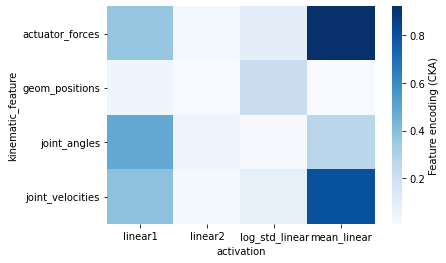

In [16]:
%matplotlib inline

df_b = pd.DataFrame(figure_5b).drop_duplicates().pivot('kinematic_feature', 'activation', 'cka')
sns.heatmap(df_b, cbar_kws={'label':'Feature encoding (CKA)'}, cmap="Blues")

# converted geom_positions to 2d data instead of the original 3d

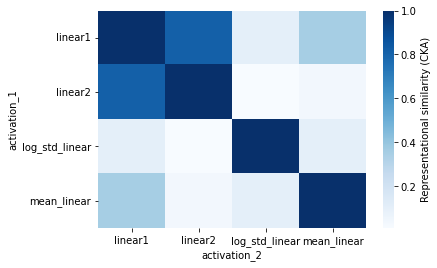

In [17]:
%matplotlib inline

df_c = pd.DataFrame(figure_5c).pivot('activation_1', 'activation_2', 'cka')
sns.heatmap(df_c, cbar_kws={'label':'Representational similarity (CKA)'}, cmap="Blues")

In [15]:
print(total_kinematic_dict.keys())
print(loaded_hook_dict.keys())

dict_keys(['geom_positions', 'joint_angles', 'joint_velocities', 'actuator_forces'])
dict_keys(['linear1', 'linear2', 'mean_linear', 'log_std_linear'])


In [19]:
%matplotlib inline
import numpy, rsatoolbox

def plot_5a(activation,kinematic):
    kmeans = KMeans(n_clusters=50, random_state=0).fit(total_kinematic_dict[kinematic])
    df = pd.DataFrame(total_kinematic_dict[kinematic])
    df['cluster_label'] = pd.Series(kmeans.labels_)

    all_calcs = []
    b = loaded_hook_dict[activation]

    for i in range(50):
      a = df[df['cluster_label']==i].drop(['cluster_label'], axis=1).values
      c = list(np.dot(a,b.T))
      all_calcs += c

    out = np.array(all_calcs)
    data = rsatoolbox.data.Dataset(out)
    rdms = rsatoolbox.rdm.calc_rdm(data)
    title = activation + ' vs. ' + kinematic
    rsatoolbox.vis.show_rdm(rdms, rdm_descriptor=title, show_colorbar='panel', figsize=(8,8))

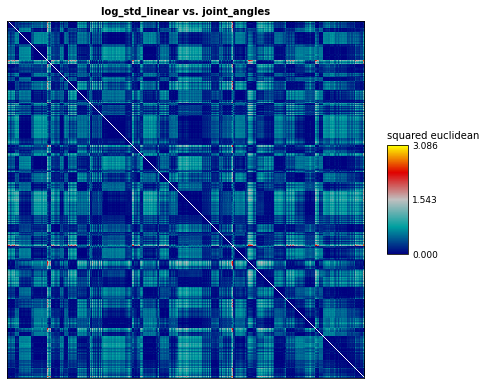

In [26]:
plot_5a('log_std_linear', 'joint_angles')

In [21]:
  kmeans = KMeans(n_clusters=50, random_state=0).fit(total_kinematic_dict['actuator_forces'])
  df = pd.DataFrame(total_kinematic_dict['actuator_forces'])
  df['cluster_label'] = pd.Series(kmeans.labels_)

In [18]:
df

,0,1,2,3,4,5,cluster_label
0,0.962013,0.631870,0.999076,0.971095,0.998166,0.971485,18
1,0.965244,0.551171,0.989854,0.938948,0.975358,0.952127,18
2,0.997088,0.322076,0.989044,0.997828,0.944490,0.974746,18
3,0.817875,0.863355,0.993402,0.950231,0.993685,0.935596,18
4,-0.976898,0.473999,-0.941880,0.888192,0.998493,0.807908,45
...,...,...,...,...,...,...,...
41995,-0.278772,-0.963125,-0.948431,0.700497,0.440761,0.544170,28
41996,-0.524206,0.580085,-0.991409,0.798113,0.966316,0.093044,45
41997,0.788512,-0.867441,-0.367085,0.818383,0.818036,-0.339185,10
41998,0.712226,0.603181,-0.880773,-0.179189,0.870130,0.265230,38


In [ ]:
all_calcs = []
b = loaded_hook_dict['mean_linear']

for i in range(50):
  a = df[df['cluster_label']==i].drop(['cluster_label'], axis=1).values
  c = list(np.dot(a,b.T))
  all_calcs += c

out = np.array(all_calcs)

In [ ]:
out

In [ ]:
# FINAL GRAPH?

%matplotlib inline

import numpy, rsatoolbox
data = rsatoolbox.data.Dataset(out)
rdms = rsatoolbox.rdm.calc_rdm(data)
rsatoolbox.vis.show_rdm(rdms, rdm_descriptor='mean_linear vs. actuator_forces', show_colorbar='panel', figsize=(8,8))

In [ ]:
df.groupby('cluster_label').mean().loc[0].values

array([ 0.72087176, -0.33247847,  0.75809966, -0.71848241, -0.76026754,
        0.14447511])

In [ ]:
# 50x6 array.  policy is 42000x256
joint_means = cluster_mean('joint_angles')

In [ ]:
loaded_hook_dict.keys()

dict_keys(['linear1', 'linear2', 'mean_linear', 'log_std_linear'])

In [ ]:
len(loaded_hook_dict['mean_linear'][0])

6

In [ ]:
# cka(loaded_hook_dict['mean_linear'].T, df[df['cluster_label'] == 1].drop(['cluster_label'], axis=1).values.T)
cka(loaded_hook_dict['mean_linear'].T, df.groupby('cluster_label').mean().loc[0].values)

0.5307534954333901

(A) Example similarity matrices
of neural networks and behavioral descriptors. We grouped behavioral descriptors into 50 clusters
that and we computed the average neural population vector during each cluster (AppendixA.4).
Similarity was assessed by computing the dot product of either the neural population vector or the
behavioral feature vector within each cluster.

In [ ]:
kmeanss = KMeans(n_clusters=50, random_state=0).fit(total_kinematic_dict['actuator_forces'])
  dff = pd.DataFrame(total_kinematic_dict['actuator_forces'])
  dff['cluster_label'] = pd.Series(kmeanss.labels_)

In [ ]:
all_calcs = []
b = total_kinematic_dict['actuator_forces']

for i in range(50):
  a = df[df['cluster_label']==i].drop(['cluster_label'], axis=1).values
  c = list(np.dot(a,b.T))
  all_calcs += c

outt = np.array(all_calcs)

(<Figure size 576x576 with 2 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa86ee0e790>]],
       dtype=object),
 defaultdict(dict,
             {<matplotlib.axes._subplots.AxesSubplot at 0x7fa86ee0e790>: {'image': <matplotlib.image.AxesImage at 0x7fa86ef8c7f0>,
               'colorbar': <matplotlib.colorbar.Colorbar at 0x7fa8625cab50>}}))

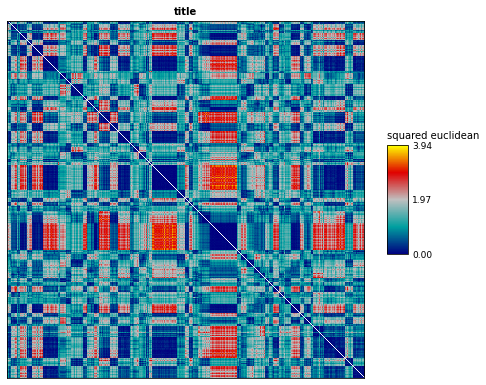

In [ ]:
%matplotlib inline

import numpy, rsatoolbox
data = rsatoolbox.data.Dataset(outt)
rdms = rsatoolbox.rdm.calc_rdm(data)
rsatoolbox.vis.show_rdm(rdms, rdm_descriptor='title', show_colorbar='panel', figsize=(8,8))

TSNE implementation

In [ ]:
from sklearn.manifold import TSNE

tsne_dict = {}
for name, arr in loaded_hook_dict.items():
    tsne = TSNE(n_components=2)
    tsne.fit(arr)
    # or fit_transform
    tsne_dict[name] = tsne

In [ ]:
def get_activations_tsne(pca_dict, compiled_hook_dict, layer_name, num_components=2):
    # get the activations
    activations = compiled_hook_dict[layer_name]
    # get the pca
    pca = pca_dict[layer_name]
    # get the transformed activations
    transformed_activations = pca.fit_transform(activations)
    return pca

In [ ]:
tsne_dict

In [ ]:
# %matplotlib inline  # uncomment if you want to see the plots inline
# plot the activations, and save the activations to a dictionary
os.makedirs('activations_tsne', exist_ok=True)

activations_dict = {}
for name, pca in pca_dict.items():
    # get activations
    activations = get_activations_tsne(pca_dict=tsne_dict, compiled_hook_dict=loaded_hook_dict, layer_name=name)

    # save activations
    activations_dict[name] = activations

    # plot activations
    save_path = 'activations_tsne/{}.png'.format(name)
    fig_im = plot_activations(activations, layer_name=name, save_path=save_path, show=True)

## Example: Using Power Spectral Density to visualize activations

In [ ]:
# filter the activations_dict to only include the layers we want
layers_to_include = ['linear1', 'linear2']

# get the activations for the layers we want
filtered_activations = {k: v for k, v in loaded_hook_dict.items() if k in layers_to_include}

# split the activations by the number of episodes collected (assumes all episodes have the same number of steps)
# get the number of steps per episode
num_steps_per_episode = activations_dict['linear1'].shape[0] // num_episodes_to_run

In [ ]:
# get the power spectral density of the pca of the activations
os.makedirs('psd', exist_ok=True)

k = 10
psd_trajectory_dict = {}
for name, activations in filtered_activations.items():
    # get the pca of the activations to k dimensions
    pca = PCA(n_components=k)
    pca.fit(activations)
    activations_pca = pca.transform(activations)  # (num_episodes_to_run * num_steps_per_episode, k)

    activations_reshaped = activations_pca.reshape(num_episodes_to_run, num_steps_per_episode, -1)  # (episodes, steps, k)
    f, psd = scipy.signal.welch(activations_reshaped, fs=50, nperseg=500, noverlap=250, axis=-2)

    psd_pca = np.average(psd, axis=-1, weights=pca.explained_variance_ratio_)  # (episodes, steps)
    psd_trajectory = np.mean(psd_pca, axis=0)  # (steps,)

    psd_trajectory_dict[name] = psd_trajectory

    # make a plot of the power spectral density
    fig, ax = plt.subplots()
    ax.semilogy(f, psd_trajectory)
    ax.set_title(name)
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('PSD [V**2/Hz]')
    # set x scale to log
    ax.set_xscale('log')

    save_path = 'psd/{}.png'.format(name)
    # save_path = None
    fig_im = fig2img(fig)
    if save_path is not None:
        fig_im.save(save_path)

# make a plot of the power spectral density of all the layers from psd_trajectory_dict
fig, ax = plt.subplots()
for name, psd_trajectory in psd_trajectory_dict.items():
    ax.semilogy(f, psd_trajectory, label=name)
ax.set_title('All layers')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
# set x scale to log
ax.set_xscale('log')
ax.legend()

save_path = 'psd/all_layers.png'
# save_path = None
fig_im = fig2img(fig)
if save_path is not None:
    fig_im.save(save_path)

### Task: Implement PCA / PSD over kinematics

## Plot in a live loop

In [ ]:
# plot a single point

time_step = env.reset()
episode_len = 0
episode_reward = 0

# create an imageio writer to a mp4
writer = imageio.get_writer('test_combined_embedding_cheetah.mp4', fps=50)

# first, clear the hooks
clear_hook_dict(hook_dict)

while not time_step.last():
    # get the state
    state = get_flat_obs(time_step)
    # sample an action
    action = agent.select_action(state)
    # step the environment
    time_step = env.step(action)

    # record from a camera
    stitched_img = create_stitched_img(env)

    # get the latest dimension and do pca
    for name, hook_list in hook_dict.items():
        latest_activation = hook_list[-1]
        point = latest_activation.detach().cpu().numpy().reshape(1, -1)
        pca = pca_dict[name]
        # grab corresponding activations
        activations = activations_dict[name]

        # plot single point
        img = plot_single_point(point=point, activations=activations, pca=pca, layer_name=name)

        # combine the two images
        stitched_img = np.concatenate((img, stitched_img), axis=1)

        # img_arr.append(combined_img)

    # write to the writer
    writer.append_data(stitched_img)

    # logging stuff
    episode_reward += time_step.reward
    episode_len += 1

    # # clear the hooks for memory purposes?
    # clear_hook_dict(hook_dict)

# close the writer
writer.close()

print('episode stats:', 'episode_len:', episode_len, 'episode_reward:', episode_reward)